# Etude de cas : régression non-paramétrique par spline cubiques


Etudiant : FACUNDO Frank


Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl

# Implementation


## Q1

Récupérer les données et construire les vecteurs $t_{i}$ et $Y_{i}$, i = 1, . . . , n (2ème et 3ème colonne du fichier,respectivement). Remarquer que l’on est dans le cas d’observations multiples de la question QP- 2.
Construire les poids $m_{i}$ et les valeurs agrégées,i = 1, . . . , n.


In [2]:
file = np.loadtxt("Motorcycledata.txt")

In [3]:
t, Y = file[:, 1], file[:, 2]

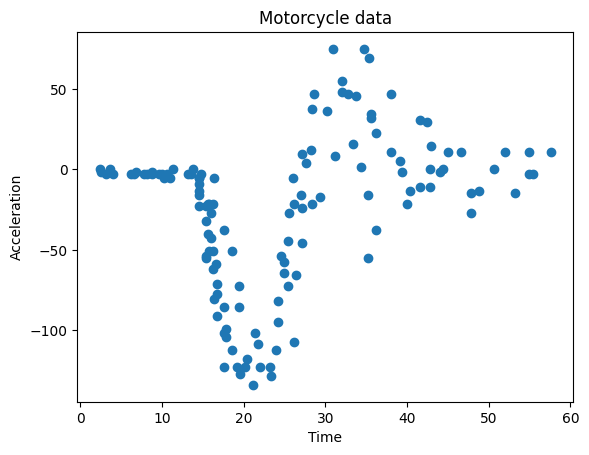

In [4]:
plt.scatter(t, Y)
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.title("Motorcycle data")
plt.show()

Get list of different time


In [18]:
listTime = []
for time in t:
    if not (time in listTime):
        listTime.append(time)

Calcul $\hat{y}$ -> Y_hat


In [6]:
n = len(listTime)
Y_hat = np.zeros(n)
# Number of occurrences of a time
m = np.zeros(n)
t = list(t)

for k in range(n):
    # tk : Single time
    tk = listTime[k]
    m[k] = t.count(tk)
    for i in range(len(t)):
        if tk == t[i]:
            Y_hat[k] += Y[i]
    Y_hat[k] /= m[k]

Y_hat


In [7]:
print(f"Total points: {len(Y)}\nTotal time points: {len(listTime)}")

Total points: 133
Total time points: 94


# Q2

Ajuster les coefficients d’un polynôme de degré m au sens des moindres carrés faire varier `m` et discuter les résultats observés


In [8]:
def Holder(P, x):
    res = 0
    # print(P)
    for k in range(len(P) - 1, -1, -1):
        res = res * x
        res = res + P[k]
    return res

In [15]:
# listTime

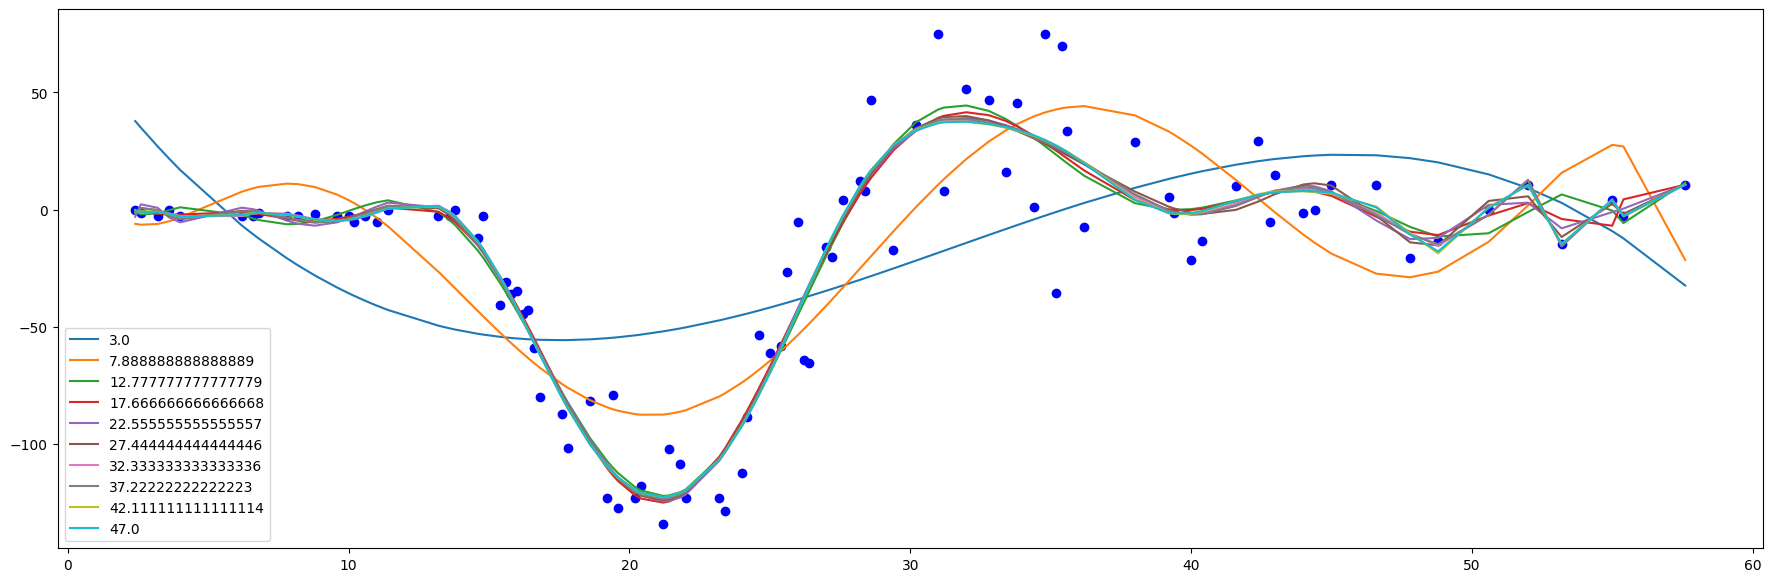

In [14]:
""" 
* M is the list of degrees
  ->  array([ 3., 14., 25., 36., 47.])
*numpy.polyfit(x, y, degree)
"""
M = np.linspace(3, n // 2, 10)
# plt.plot(listTime, Y_hat, label = "Data", color = "black")
plt.figure(figsize=(22, 7))
plt.scatter(listTime, Y_hat, c="b")

for k in range(len(M)):
    P = np.polynomial.polynomial.polyfit(listTime, Y_hat, int(M[k]))
    YPred = [Holder(P, tk) for tk in listTime]
    plt.plot(listTime, YPred, label=M[k])

# plt.xlim(right=100)  # Set the x-axis to show until 100
plt.legend()
plt.show()

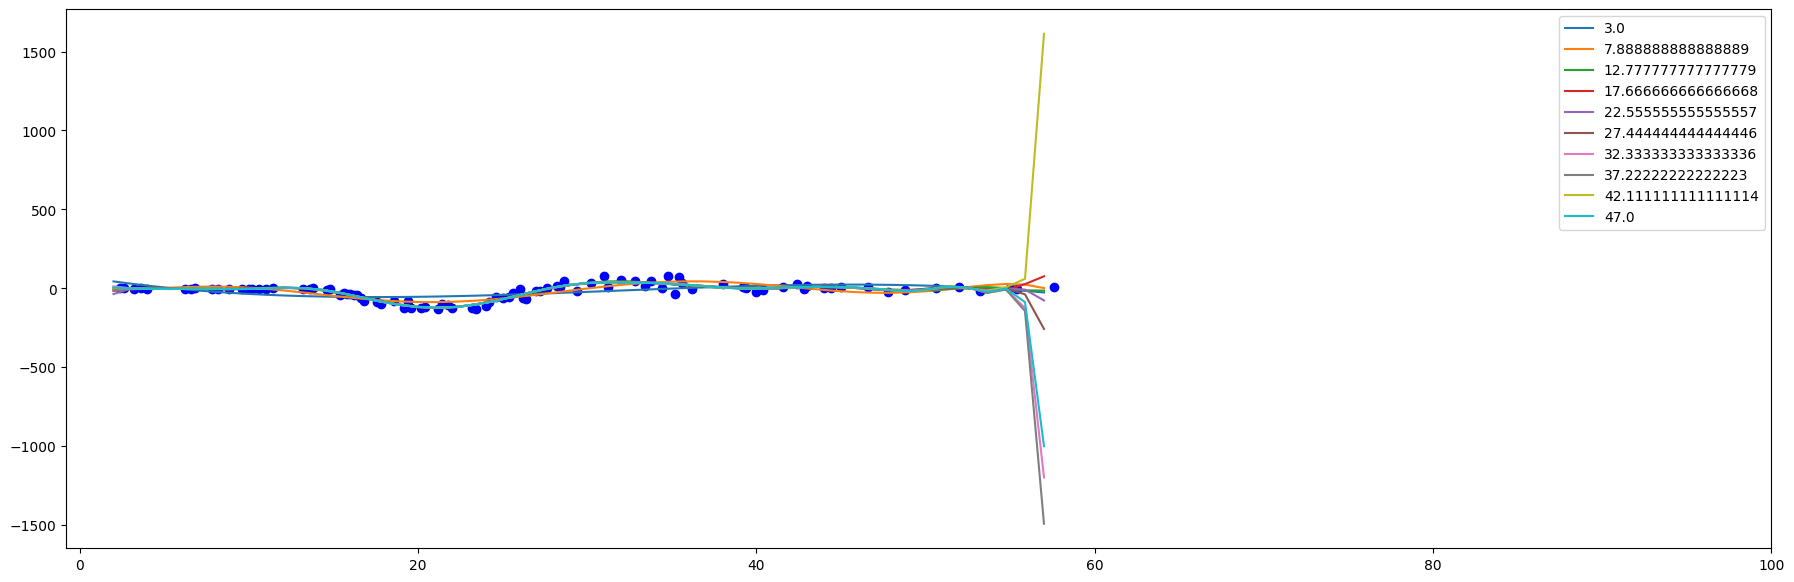

In [36]:
""" 
* M is the list of degrees
  ->  array([ 3., 14., 25., 36., 47.])
*numpy.polyfit(x, y, degree)
"""
M = np.linspace(3, n // 2, 10)
# plt.plot(listTime, Y_hat, label = "Data", color = "black")
plt.figure(figsize=(22, 7))
plt.scatter(listTime, Y_hat, c="b")

listTime_extended = np.linspace(2, 57)

for k in range(len(M)):
    P = np.polynomial.polynomial.polyfit(listTime, Y_hat, int(M[k]))
    YPred = [Holder(P, tk) for tk in listTime_extended]
    plt.plot(listTime_extended, YPred, label=M[k])

    # YPred = [Holder(P, tk) for tk in listTime]
    # plt.plot(listTime, YPred, label=M[k])

plt.xlim(right=100)  # Set the x-axis to show until 100
plt.legend()
plt.show()

Prédire futurs valeurs avec m > 20 donne des résultats trop grandes.


# Q3


### METHODE DE REGRESSION SPLINE


### Calcul de la matrice K


#### 1.Implementation de la matrice Q:


In [37]:
n = 94

In [38]:
h = np.ones(n - 1)
for i in range(n - 1):
    h[i] = listTime[i + 1] - listTime[i]

In [39]:
h.shape

(93,)

In [40]:
n = len(h)
n

93

In [41]:
Q = np.zeros((n + 1, n - 1))
# j=1
for j in range(n - 1):
    # print(j)
    Q[j][j] = 1 / h[j]
    Q[j + 1][j] = -1 / h[j] - 1 / h[j + 1]
    Q[j + 2][j] = 1 / h[j + 1]

#### 2.Implementation de la matrice R:


In [42]:
R = np.zeros((n - 1, n - 1))
for i in range(n - 1):
    R[i][i] = 1 / 3 * (h[i + 1] + h[i])
for i in range(n - 2):
    R[i][i + 1] = 1 / 6 * (h[i])
    R[i + 1][i] = R[i][i + 1]

In [43]:
K = (Q @ np.linalg.inv(R)) @ Q.T

In [44]:
m.shape

(94,)

In [45]:
I = np.eye(n + 1, n + 1)
I_n = np.multiply(I, m)

In [46]:
def spline(alpha):
    A_W = np.dot(np.linalg.inv(I_n + alpha * K), I_n)
    g = np.dot(A_W, Y_hat)
    return g

In [47]:
S0 = spline(5)

In [48]:
S1 = spline(10)

In [49]:
S2 = spline(20)

In [50]:
S3 = spline(30)

In [51]:
S1.shape

(94,)

### Graphique avec la methode Spline


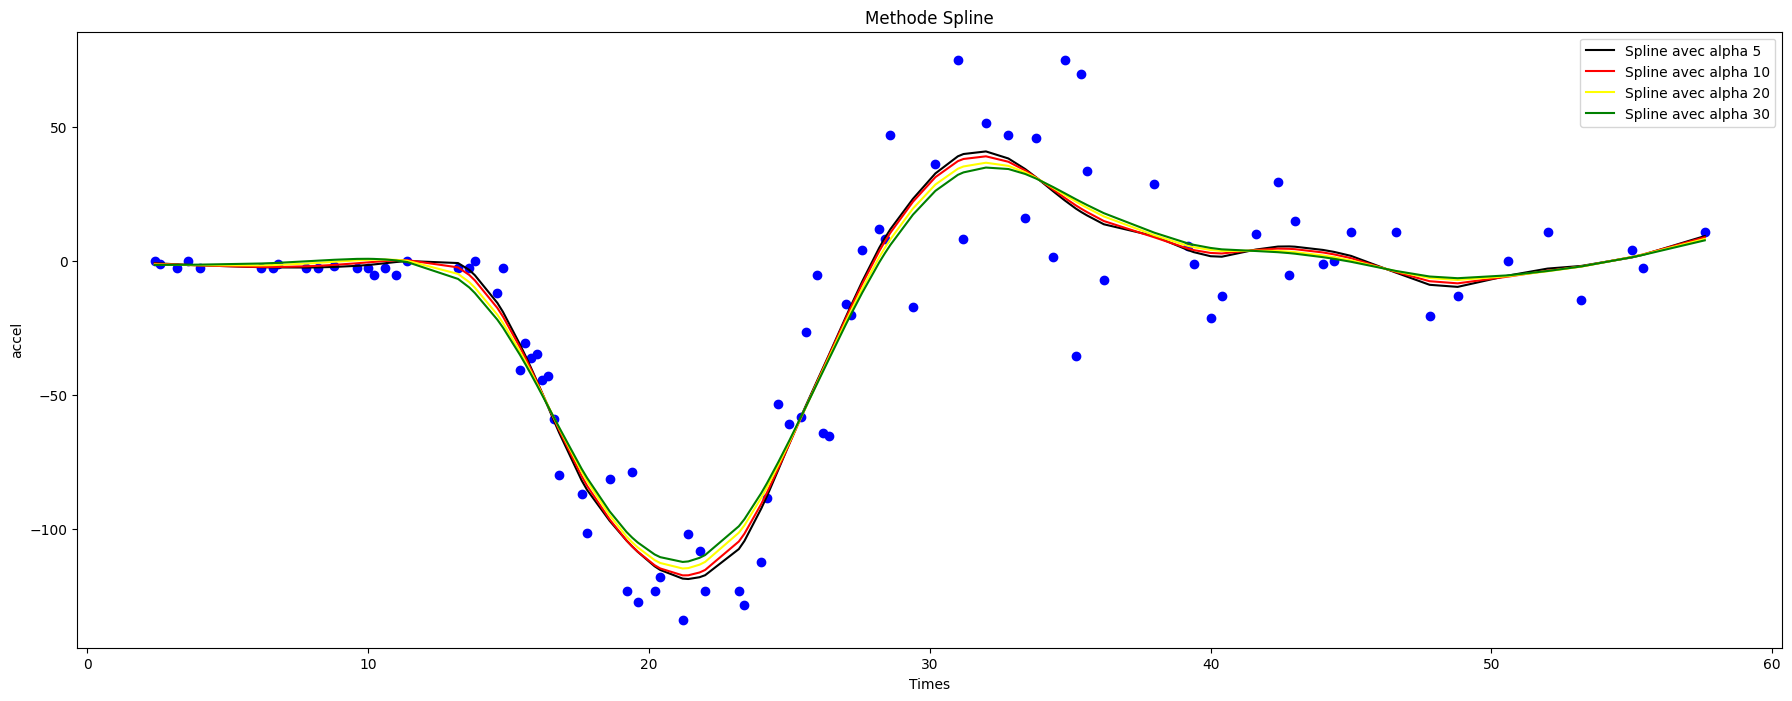

In [52]:
plt.figure(figsize=(22, 8))
plt.title("Methode Spline")
plt.scatter(listTime, Y_hat, c="b")
plt.plot(listTime, S0, color="black", label="Spline avec alpha 5")
plt.plot(listTime, S1, color="red", label="Spline avec alpha 10")
plt.plot(listTime, S2, color="yellow", label="Spline avec alpha 20")
plt.plot(listTime, S3, color="green", label="Spline avec alpha 30")
plt.ylabel("accel")
plt.xlabel("Times")
plt.legend()
plt.show()

### QUESTION 4:


Implementer la methode de validation croisee et calculer CV (α) pour des valeurs de α
entre 1 et 100. Minimiser en alpha numériquement.


In [61]:
alpha1 = np.linspace(1, 100, 100)

### Validation Croisee


In [62]:
def CV(alpha):
    cv = 0
    s = 94
    wi = np.ones(s)
    A_W = np.dot(np.linalg.inv(I_n + alpha * K), I_n)
    for i in range(n):
        wi[i] = m[i]
        cv = cv + wi[i] * ((Y_hat[i] - spline(alpha)[i]) / (1 - A_W[i][i])) ** 2
    return cv / s

In [63]:
calc_CV = np.ones(100)
for i in range(100):
    calc_CV[i] = CV(alpha1[i])

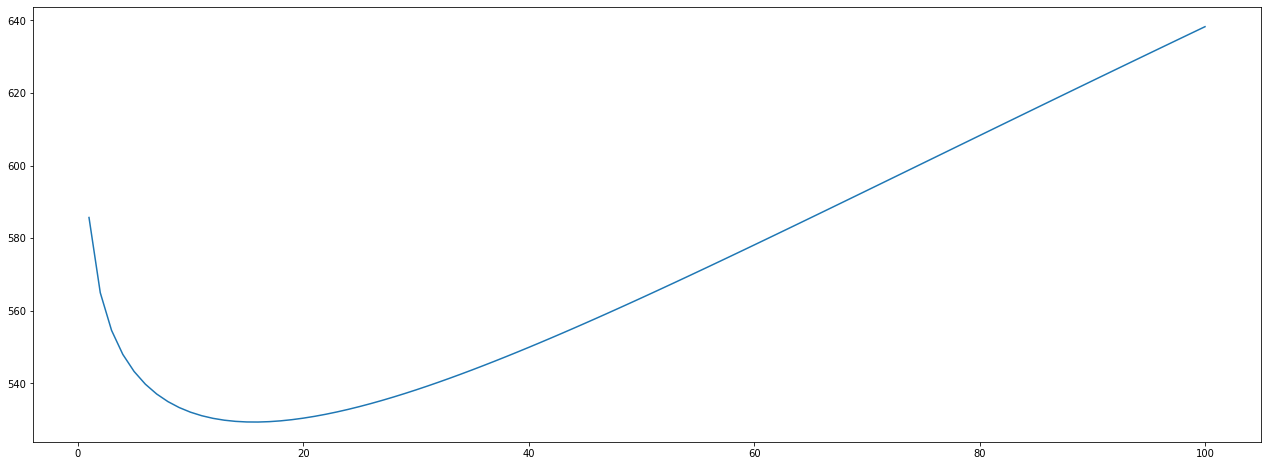

In [81]:
plt.figure(figsize=(22, 8))
plt.plot(alpha1, calc_CV)
plt.show()

#### Trouver le minimun:


In [65]:
mini = np.min(calc_CV)
mini

529.3028942685297

In [71]:
valeur = np.argmin(calc_CV)
valeur += 1

In [72]:
valeur

16

### Question 5


### Validation Croisee Generalisée


In [77]:
def CVG(alpha):
    cvg = 0
    n = 94
    wi = np.ones(n)
    A_W = np.dot(np.linalg.inv(I_n + alpha * K), I_n)
    for i in range(n):
        wi[i] = m[i]
        cvg += wi[i] * (Y_hat[i] - spline(alpha)[i]) ** 2
    cvg = cvg / (((1 - (np.trace(A_W)) / n) ** 2) * n)
    return cvg

In [78]:
calc_CVG = np.ones(100)
for i in range(100):
    calc_CVG[i] = CVG(alpha1[i])

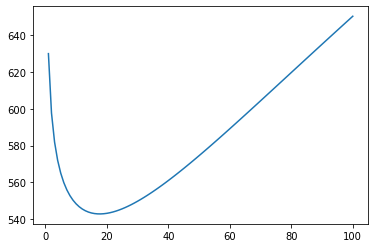

In [79]:
plt.plot(alpha1, calc_CVG)
plt.show()

In [80]:
valeur_1 = alpha1[np.argmin(calc_CVG)]
valeur_1

18.0